In [1]:
# @title установка драйверов
!apt-get update > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install -y swig build-essential python-dev python3-dev > /dev/null 2>&1
!apt-get install x11-utils > /dev/null 2>&1
!apt-get install xvfb > /dev/null 2>&1

In [2]:
# @title установка библиотек
%%capture
!pip install rarfile --quiet
!pip install stable-baselines3[extra] --quiet
!pip install ale-py --quiet
!pip install gym[box2d] --quiet
!pip install pyvirtualdisplay --quiet
!pip install pyglet --quiet
!pip install pygame --quiet
!pip install minigrid --quiet
!pip install -q swig --quiet
!pip install -q gymnasium[box2d] --quiet
!pip install 'minigrid<=2.1.1' --quiet
!pip3 install box2d-py --quiet

In [3]:
# @title Импортирование библиотек
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import sys
import gymnasium
sys.modules["gym"] = gymnasium

import gymnasium as gym
from gym import spaces
from gym.envs.box2d.lunar_lander import *
from gym.wrappers.monitoring.video_recorder import VideoRecorder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Create DQN pipeline

In [4]:
# @title Replay memory
import random
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# @title Create DQN class
import torch
import torch.nn.functional as F
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions, dropout=None): # добавил функции дропаута чтобы посмотреть на реакцию RL на это
        super(DQN, self).__init__()

        self.dropout = dropout

        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
          if self.dropout is None:
            x = F.relu(self.layer1(x))
            x = F.relu(self.layer2(x))
          else:
            x = self.layer1(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = F.relu(x)
            x = self.layer2(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = F.relu(x)

          return self.layer3(x)

In [6]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 3e-4
FULL_MEMORY_LENGTH = 10000

In [7]:
env = gym.make(
    "LunarLander-v2",
    continuous = False,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 15.0,
    turbulence_power = 1.5,
)

n_actions = env.action_space.n

state, info = env.reset()
n_observations = len(state)

## Initialize NNs


In [8]:
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)

policy_net_dp = DQN(n_observations, n_actions, 0.1).to(device)
target_net_dp = DQN(n_observations, n_actions, 0.1).to(device)

target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

memory = ReplayMemory(FULL_MEMORY_LENGTH)

steps_done = 0

episode_durations = []

In [9]:
def select_action(state):
    global steps_done
    sample = random.random()

    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)

    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
def optimize_model(batch_size: int):
    if len(memory) < batch_size:
        return

    # Получить из памяти батч
    transitions = memory.sample(batch_size)
    # Преобразовать его в namedtuple
    batch = Transition(*zip(*transitions))

    # Вычислить маску нефинальных состояний и соединить элементы батча
    # (финальным состоянием должно быть то, после которого моделирование закончилось)

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), device=device, dtype=torch.bool)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])

    # Собираем батчи для состояний, действий и наград
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Вычислить Q(s_t, a) - модель вычисляет Q(s_t),
    # затем мы выбираем столбцы предпринятых действий.
    # Это те действия, которые были бы предприняты для каждого состояния партии в соответствии с policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Вычислить V(s_{t+1}) для всех следующих состояний.
    # Ожидаемые значения действий для не_финальных_следующих_состояний вычисляются
    # на основе "старшей" целевой_сети; выбирается их наилучшее вознаграждение с помощью max(1)[0].
    # Это объединяется по маске, так что мы будем иметь либо ожидаемое значение состояния,
    # либо 0, если состояние было финальным.
    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Вычисляем ожидаемые Q значения
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Объединяем все в общий лосс
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Готовим градиент
    optimizer.zero_grad()
    loss.backward()
    # Обрезаем значения градиента - проблемма исчезающего/взрывающего градиента
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)

    optimizer.step()

In [11]:
if torch.cuda.is_available():
    num_episodes = 1500
else:
    num_episodes = 500
total_reward = []

for i_episode in tqdm(range(num_episodes)):
    episode_reward = 0
    # Для каждого эпизода инициализируем начальное состояние
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    # выполняем действия пока не получим флаг done
    # t - считает сколько шагов успели сделать пока шест не упал
    for t in count():
        # выбираем действие [0, 1]
        action = select_action(state)
        # Делаем шаг
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward += reward

        # Преобразуем в тензор
        reward = torch.tensor([reward], device=device)

        # Объединяем done по двум конечным состояниям
        done = terminated or truncated

        # присваиваем следующее состояние
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # отправляем в память
        memory.push(state, action, next_state, reward)

        # переходим на следующее состояние
        state = next_state

        # запускаем обучение сети
        optimize_model(batch_size=128)

        # делаем "мягкое" обновление весов
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()

        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        # Если получили terminated or truncated завершаем эпизод обучения
        if done:
            # добавляем в массив продолжительность эпизода
            episode_durations.append(t + 1)
            total_reward.append(episode_reward)
            break

print('Complete')


100%|██████████| 1500/1500 [34:53<00:00,  1.40s/it]

Complete


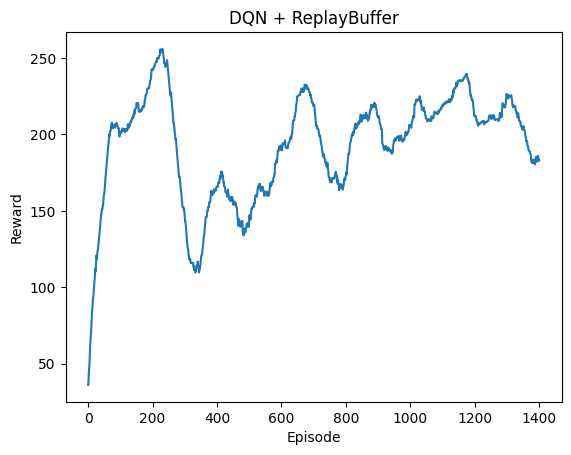

In [12]:
# Вычисление скользящего среднего
window_size = 100
moving_avg = np.convolve(total_reward, np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_avg)
plt.title('DQN + ReplayBuffer')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

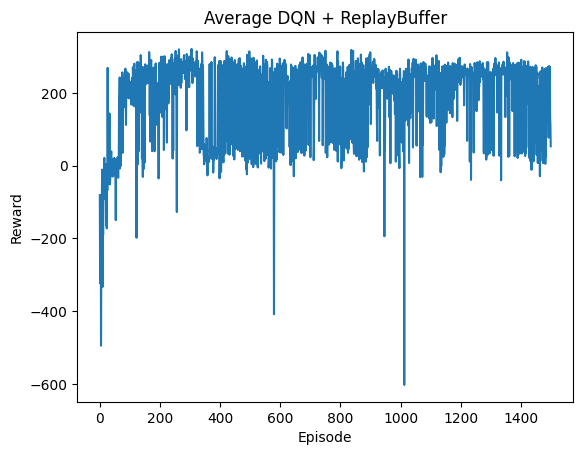

In [14]:
# Вывод среднего
plt.plot(total_reward)
plt.title('Average DQN + ReplayBuffer')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

## Use dropout

In [15]:
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)

policy_net_dp = DQN(n_observations, n_actions, 0.1).to(device)
target_net_dp = DQN(n_observations, n_actions, 0.1).to(device)

target_net_dp.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

memory = ReplayMemory(FULL_MEMORY_LENGTH)

steps_done = 0

episode_durations = []

In [16]:
def select_action(state):
    global steps_done
    sample = random.random()

    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)

    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [19]:
def optimize_model_dp(batch_size: int):
    if len(memory) < batch_size:
        return

    # Получить из памяти батч
    transitions = memory.sample(batch_size)
    # Преобразовать его в namedtuple
    batch = Transition(*zip(*transitions))

    # Вычислить маску нефинальных состояний и соединить элементы батча
    # (финальным состоянием должно быть то, после которого моделирование закончилось)

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), device=device, dtype=torch.bool)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])

    # Собираем батчи для состояний, действий и наград
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Вычислить Q(s_t, a) - модель вычисляет Q(s_t),
    # затем мы выбираем столбцы предпринятых действий.
    # Это те действия, которые были бы предприняты для каждого состояния партии в соответствии с policy_net
    state_action_values = policy_net_dp(state_batch).gather(1, action_batch)

    # Вычислить V(s_{t+1}) для всех следующих состояний.
    # Ожидаемые значения действий для не_финальных_следующих_состояний вычисляются
    # на основе "старшей" целевой_сети; выбирается их наилучшее вознаграждение с помощью max(1)[0].
    # Это объединяется по маске, так что мы будем иметь либо ожидаемое значение состояния,
    # либо 0, если состояние было финальным.
    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net_dp(non_final_next_states).max(1)[0]
    # Вычисляем ожидаемые Q значения
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Объединяем все в общий лосс
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Готовим градиент
    optimizer.zero_grad()
    loss.backward()
    # Обрезаем значения градиента - проблемма исчезающего/взрывающего градиента
    torch.nn.utils.clip_grad_value_(policy_net_dp.parameters(), 100)

    optimizer.step()

In [20]:
if torch.cuda.is_available():
    num_episodes = 1500
else:
    num_episodes = 500
total_reward = []

for i_episode in tqdm(range(num_episodes)):
    episode_reward = 0
    # Для каждого эпизода инициализируем начальное состояние
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    # выполняем действия пока не получим флаг done
    # t - считает сколько шагов успели сделать пока шест не упал
    for t in count():
        # выбираем действие [0, 1]
        action = select_action(state)
        # Делаем шаг
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward += reward

        # Преобразуем в тензор
        reward = torch.tensor([reward], device=device)

        # Объединяем done по двум конечным состояниям
        done = terminated or truncated

        # присваиваем следующее состояние
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # отправляем в память
        memory.push(state, action, next_state, reward)

        # переходим на следующее состояние
        state = next_state

        # запускаем обучение сети
        optimize_model_dp(batch_size=128)

        # делаем "мягкое" обновление весов
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net_dp.state_dict()
        policy_net_state_dict = policy_net_dp.state_dict()

        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net_dp.load_state_dict(target_net_state_dict)

        # Если получили terminated or truncated завершаем эпизод обучения
        if done:
            # добавляем в массив продолжительность эпизода
            episode_durations.append(t + 1)
            total_reward.append(episode_reward)
            break

print('Complete')


100%|██████████| 1500/1500 [07:47<00:00,  3.21it/s]

Complete


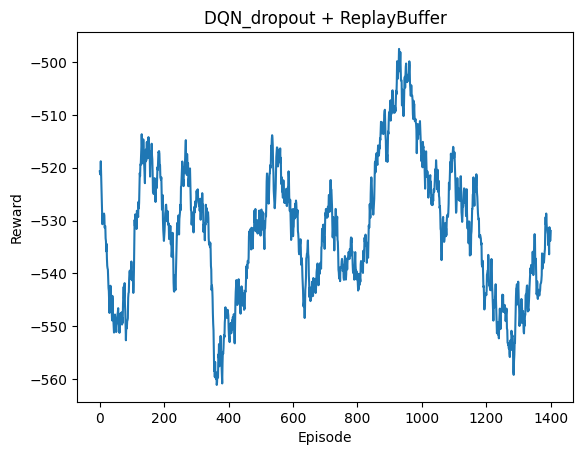

In [21]:
# Вычисление скользящего среднего
window_size = 100
moving_avg = np.convolve(total_reward, np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_avg)
plt.title('DQN_dropout + ReplayBuffer')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

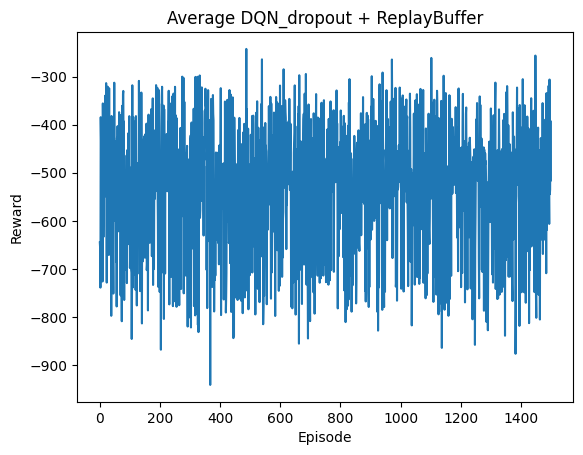

In [22]:
# Вывод среднего
plt.plot(total_reward)
plt.title('Average DQN_dropout + ReplayBuffer')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

Вывод: добавление случайности в чсеть делает DQN-подход нестабильным.

# Use twin DQN

In [ ]:
policy_net = DQN(n_observations, n_actions).to(device)
target_net_1 = DQN(n_observations, n_actions).to(device)
target_net_2 = DQN(n_observations, n_actions).to(device) # делаем сеть близнеца

target_net_1.load_state_dict(policy_net.state_dict())
target_net_2.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

memory = ReplayMemory(FULL_MEMORY_LENGTH)

steps_done = 0

episode_durations = []

In [ ]:
def select_action(state):
    global steps_done
    sample = random.random()

    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)

    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [ ]:
def optimize_model_twin(batch_size: int):
    if len(memory) < batch_size:
        return

    # Получить из памяти батч
    transitions = memory.sample(batch_size)
    # Преобразовать его в namedtuple
    batch = Transition(*zip(*transitions))

    # Вычислить маску нефинальных состояний и соединить элементы батча
    # (финальным состоянием должно быть то, после которого моделирование закончилось)

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), device=device, dtype=torch.bool)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])

    # Собираем батчи для состояний, действий и наград
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Вычислить Q(s_t, a) - модель вычисляет Q(s_t),
    # затем мы выбираем столбцы предпринятых действий.
    # Это те действия, которые были бы предприняты для каждого состояния партии в соответствии с policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Вычислить V(s_{t+1}) для всех следующих состояний.
    # Ожидаемые значения действий для не_финальных_следующих_состояний вычисляются
    # на основе "старшей" целевой_сети; выбирается их наилучшее вознаграждение с помощью max(1)[0].
    # Это объединяется по маске, так что мы будем иметь либо ожидаемое значение состояния,
    # либо 0, если состояние было финальным.
    next_state_values_1 = torch.zeros(batch_size, device=device)
    next_state_values_2 = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        next_action_1 = target_net_1(non_final_next_states).argmax(1, keepdim=True)
        next_action_2 = target_net_2(non_final_next_states).argmax(1, keepdim=True)
        next_state_values_1[non_final_mask] = torch.min(target_net_1(non_final_next_states).gather(1,next_action_1).squeeze(),target_net_2(non_final_next_states).gather(1,next_action_1).squeeze())
        next_state_values_2[non_final_mask] = torch.min(target_net_1(non_final_next_states).gather(1,next_action_2).squeeze(),target_net_2(non_final_next_states).gather(1,next_action_2).squeeze())
    # реализуем twin алгоритм

    # Вычисляем ожидаемые Q значения
    expected_state_action_values = ((next_state_values_1 * GAMMA) + (next_state_values_2 * GAMMA) + 2*reward_batch)/2

    # Объединяем все в общий лосс
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Готовим градиент
    optimizer.zero_grad()
    loss.backward()
    # Обрезаем значения градиента - проблемма исчезающего/взрывающего градиента
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)

    optimizer.step()

In [ ]:
if torch.cuda.is_available():
    num_episodes = 1500
else:
    num_episodes = 500
total_reward = []

for i_episode in tqdm(range(num_episodes)):
    episode_reward = 0
    # Для каждого эпизода инициализируем начальное состояние
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    # выполняем действия пока не получим флаг done
    # t - считает сколько шагов успели сделать пока шест не упал
    for t in count():
        # выбираем действие [0, 1]
        action = select_action(state)
        # Делаем шаг
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward += reward

        # Преобразуем в тензор
        reward = torch.tensor([reward], device=device)

        # Объединяем done по двум конечным состояниям
        done = terminated or truncated

        # присваиваем следующее состояние
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # отправляем в память
        memory.push(state, action, next_state, reward)

        # переходим на следующее состояние
        state = next_state

        # запускаем обучение сети
        optimize_model_twin(batch_size=128)

        # делаем "мягкое" обновление весов
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict_1 = target_net_1.state_dict()
        target_net_state_dict_2 = target_net_2.state_dict()
        policy_net_state_dict = policy_net.state_dict()

        for key in policy_net_state_dict:
            target_net_state_dict_1[key] = policy_net_state_dict[key]*TAU + target_net_state_dict_1[key]*(1-TAU)
            target_net_state_dict_2[key] = policy_net_state_dict[key]*TAU + target_net_state_dict_2[key]*(1-TAU)
        target_net_1.load_state_dict(target_net_state_dict_1)
        target_net_2.load_state_dict(target_net_state_dict_2)

        # Если получили terminated or truncated завершаем эпизод обучения
        if done:
            # добавляем в массив продолжительность эпизода
            episode_durations.append(t + 1)
            total_reward.append(episode_reward)
            break

print('Complete')


100%|██████████| 1500/1500 [1:01:24<00:00,  2.46s/it]

Complete


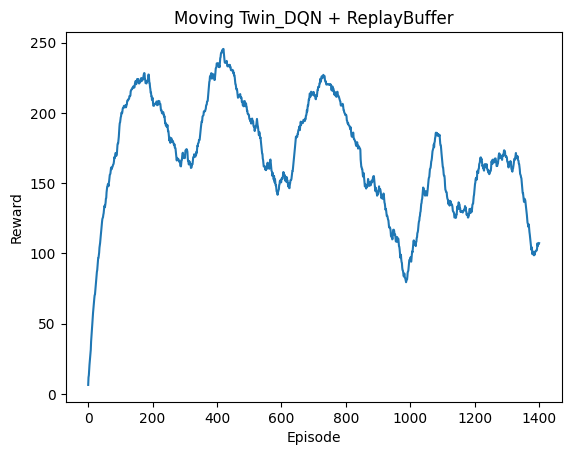

In [ ]:
# Вычисление скользящего среднего
window_size = 100
moving_avg = np.convolve(total_reward, np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_avg)
plt.title('Moving Twin_DQN + ReplayBuffer')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


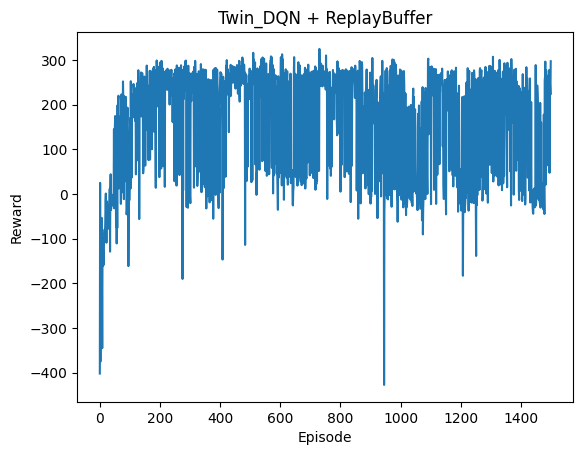

In [ ]:
# # Среднее
plt.plot(total_reward)
plt.title('Average Twin_DQN + ReplayBuffer')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

Вывод: награда выше чем у обычного DQN, но странно выглядит окно в 100 значений, как будто здесь сходимость менее быстрая, чем в случае DQN